In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Use os.listdir() to get all the names within the folder
all_names = os.listdir('results')

# Filter out the names that correspond to folders
cities = [name for name in all_names if os.path.isdir(os.path.join('results', name))]

In [150]:
def plot_unavailable_images(all_cities_results):
    grouped = all_cities_results.groupby(
        ["highway", "city"]
        ).agg(
            {"total_null": "sum", 
             "proportion_null": "sum"})
    
    grouped2 = grouped.groupby("highway").agg({"total_null": "sum"})

    # Sort the grouped DataFrame by 'total_null' column in descending order and select the top 5 rows
    top_5_highways = list(grouped2.nlargest(5, 'total_null').index)

    grouped = grouped.loc[top_5_highways]

    # Reset the index for proper sorting and grouping
    grouped = grouped.reset_index()
    
    grouped = grouped.sort_values(by="proportion_null", ascending=False)
    
    custom_palette = ["#D53E4F", "#FC8D59", "#FEE08B", "#FFFFBF", "#E6F598", "#99D594", "#3288BD"]

    # Create a bar plot for the top 5 highway types
    bar1 = sns.barplot(data=grouped, x="proportion_null", y="highway", hue="city", palette=custom_palette)

    # Create custom legend handles and labels for bar1
    handles1, labels1 = bar1.get_legend_handles_labels()
    # Add the legends outside of the plot
    plt.legend(handles1, labels1, title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set labels and title
    plt.title('Top 5 Highway Types with Most Missing Images')
    
    plt.xlabel('Highway Types')
    plt.ylabel('Proportion of Missing Images by Highway Type')
    
    # Set the maximum value for the y-axis
    plt.xlim(0, 1)

    # Show the plot
    plt.show()
    
    # Set the figure size
    bar1.figure.set_size_inches(8, 6)  # Adjust the width and height as needed

    bar1.figure.savefig('myimage_multicolor.svg', format='svg', bbox_inches='tight')

In [5]:
def get_unavailable_images(intersection, city):
    grouped = intersection.groupby(['road_index_x', 'highway']).agg({
        'image_id': lambda x: (~x.isnull()).sum(),            # Count number of points with missing images
    }).reset_index()

    grouped.columns = ['road_index', 'highway', 'total_null']
    
    count = grouped.groupby('highway').agg({
        'total_null': 'sum',
    }).sort_values('total_null', ascending=False)

    count['city'] = city

    count['proportion_null'] = count["total_null"] / len(intersection)
    
    return count

In [6]:
# Create an empty DataFrame to store aggregated results from all cities
all_cities_results = pd.DataFrame()
results = {}

for city in cities:
    dir_path = os.path.join("results", city)

    # Load roads layer
    roads_path = os.path.join(dir_path, "gvi", "gvi-streets.gpkg")
    roads = gpd.read_file(roads_path, layer="gvi-streets")

    # Load points with gvi layer
    points_path = os.path.join(dir_path, "gvi", "gvi-points.gpkg")
    points = gpd.read_file(points_path, layer="gvi-points", crs=4326)
    points.to_crs(crs=roads.crs, inplace=True)

    # Load points with roads layer
    points_road_path = os.path.join(dir_path, "points", "points.gpkg")
    points_road = gpd.read_file(points_road_path, layer="points", crs=4326)
    points_road.to_crs(crs=roads.crs, inplace=True)

    points_road = points_road.merge(points, on="id")

    # Merge the previous dataframe with the roads dataframe
    intersection = points_road.merge(roads, left_on="road_index", right_on="index")

    intersection = intersection[["id", "image_id", "distance", "is_panoramic_x", "road_index_x", "geometry_x", "GVI", "length", "highway"]]

    results[city] = intersection

    count = get_unavailable_images(intersection, city)

    # Append the results of each city to the all_cities_results DataFrame
    all_cities_results = pd.concat([all_cities_results, count])

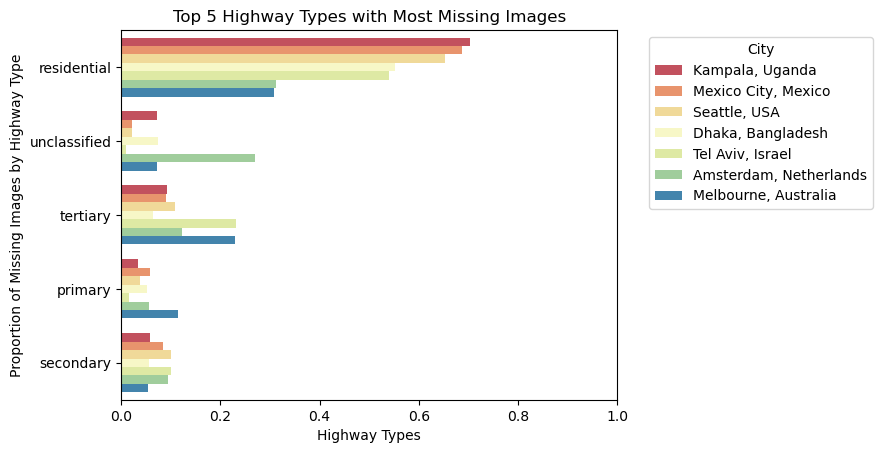

In [151]:
plot_unavailable_images(all_cities_results)

### Missing images

In [7]:
# Table with number null images

# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['unavailable', 'unsuitable', 'total_null', 'percentage_null', 'total_points'])

for city in cities:
    df = results[city]

    unavailable = df[df["image_id"] == ""].count()[0]
    unsuitable = df[(df["GVI"].isnull()) & (df["image_id"]!="")].count()[0]
    total_null = df[df["GVI"].isnull()].count()[0]
    total = df.count()[0]
    percentage_null = total_null / total

    result_table.loc[city] = [unavailable, unsuitable, total_null, percentage_null, total]

In [8]:
result_table.sort_values(by="percentage_null")

,unavailable,unsuitable,total_null,percentage_null,total_points
"Amsterdam, Netherlands",494.0,1632.0,2126.0,0.055172,38534.0
"Melbourne, Australia",1691.0,951.0,2642.0,0.254430,10384.0
"Seattle, USA",14770.0,8127.0,22897.0,0.370496,61801.0
"Mexico City, Mexico",170830.0,21118.0,191948.0,0.621545,308824.0
"Dhaka, Bangladesh",51474.0,5111.0,56585.0,0.685447,82552.0
"Tel Aviv, Israel",10591.0,1373.0,11964.0,0.707259,16916.0
"Kampala, Uganda",26751.0,6373.0,33124.0,0.809620,40913.0


### Panoramic images

In [9]:
# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['Panoramic Images', 'Total Images', "Proportion"])

for city in cities:
    df = results[city]

    is_panoramic = df[df["is_panoramic_x"]].count()[0]
    total = df[df["image_id"] != ""].count()[0]

    result_table.loc[city] = [is_panoramic, total, is_panoramic/total]

In [10]:
result_table.sort_values(by="Proportion")

,Panoramic Images,Total Images,Proportion
"Dhaka, Bangladesh",0.0,31078.0,0.000000
"Mexico City, Mexico",689.0,137994.0,0.004993
"Melbourne, Australia",52.0,8693.0,0.005982
"Kampala, Uganda",197.0,14162.0,0.013910
"Tel Aviv, Israel",128.0,6325.0,0.020237
"Seattle, USA",7069.0,47031.0,0.150305
"Amsterdam, Netherlands",32216.0,38040.0,0.846898


### Availability Score and Adjusted Availability Score

In [11]:
# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['GVI Points', 'Road Length', 'Total Sample', 'Availability Score', 'Adjusted Availability Score'])

for city in cities:
    df = results[city]
    gvi_points = df[df["image_id"]!=""].count()[0]
    road_length = df["length"].sum() / 1000
    total = df.count()[0]

    result_table.loc[city] = [gvi_points, road_length, total, gvi_points/total, (gvi_points  * np.log(road_length))/total]

In [12]:
result_table.sort_values(by="Adjusted Availability Score")

,GVI Points,Road Length,Total Sample,Availability Score,Adjusted Availability Score
"Tel Aviv, Israel",6325.0,3149.644784,16916.0,0.373906,3.011833
"Kampala, Uganda",14162.0,7903.787527,40913.0,0.346149,3.106722
"Dhaka, Bangladesh",31078.0,18044.102487,82552.0,0.376466,3.689580
"Mexico City, Mexico",137994.0,70205.492611,308824.0,0.446837,4.986336
"Melbourne, Australia",8693.0,2221.459293,10384.0,0.837153,6.451036
"Seattle, USA",47031.0,13439.004521,61801.0,0.761007,7.234070
"Amsterdam, Netherlands",38040.0,11218.417615,38534.0,0.987180,9.205763


### Quality Score and Adjusted Quality Score

In [13]:
# Create an empty DataFrame to store the results
result_table = pd.DataFrame(columns=['GVI Points', 'Road Length', 'Total Sample', 'Quality Score', 'Adjusted Quality Score'])

for city in cities:
    df = results[city]
    gvi_points = df[(~df["GVI"].isnull()) & (df["image_id"]!="")].count()[0]
    road_length = df["length"].sum() / 1000
    total = df[df["image_id"]!=""].count()[0]

    result_table.loc[city] = [gvi_points, road_length, total, gvi_points/total, (gvi_points  * np.log(road_length))/total]

In [14]:
result_table.sort_values(by="Adjusted Quality Score")

,GVI Points,Road Length,Total Sample,Quality Score,Adjusted Quality Score
"Kampala, Uganda",7789.0,7903.787527,14162.0,0.549993,4.936240
"Tel Aviv, Israel",4952.0,3149.644784,6325.0,0.782925,6.306495
"Melbourne, Australia",7742.0,2221.459293,8693.0,0.890602,6.862905
"Seattle, USA",38904.0,13439.004521,47031.0,0.827199,7.863285
"Dhaka, Bangladesh",25967.0,18044.102487,31078.0,0.835543,8.188799
"Amsterdam, Netherlands",36408.0,11218.417615,38040.0,0.957098,8.925236
"Mexico City, Mexico",116876.0,70205.492611,137994.0,0.846964,9.451429
